In [17]:
import torch 
from torch.nn import Module
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# df = pd.read_csv('C:/Users/louis/github_vs/archive/Submission.csv')
df = pd.read_csv('C:/Users/louis/github_vs/archive/fer2013/fer2013/fer2013.csv')

def get_data(str):
    data = df[df["Usage"]==str]
    data_y = data['emotion'].reset_index(drop=True)
    data_x = data['pixels'].apply( lambda x : (np.array(x.split(" ")).astype('float')/255).reshape(-1,48,48))
    data_xy = [(x,y) for x,y in zip(data_y,data_x)]
    return data_xy

batch_size = 16
trainloader = torch.utils.data.DataLoader(get_data("Training"), shuffle = False,batch_size = batch_size)
valloader = torch.utils.data.DataLoader(get_data("PublicTest"), shuffle = False,batch_size = batch_size)
testloader = torch.utils.data.DataLoader(get_data("PrivateTest"), shuffle = False,batch_size = batch_size)

class_names = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']


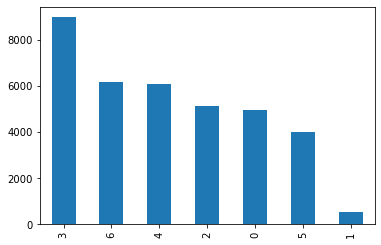

In [112]:
df['emotion'].value_counts().plot(kind = "bar")

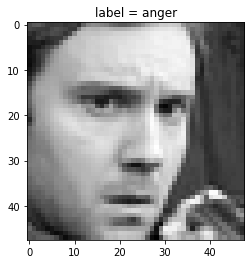

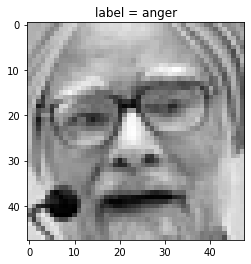

In [21]:
it = iter(trainloader)
out = it.next()
labels = out[0]
imgs= out[1]
for i in range(2):
    plt.figure()
    plt.imshow(imgs[i][0],cmap='gray')
    plt.title("label = "+class_names[labels[i]])

In [101]:
out_size = len(class_names);
scaler = 4
     
class Net(Module):   
    def __init__(self,order,filter_size,stride_size,pool_size,dropout_rate):
        super(Net, self).__init__()

        def get_layers(order,filter_size,stride_size,pool_size,dropout_rate):
            input_size = 48
            layers = []
            layers.append(nn.Conv2d(in_channels =1, out_channels = scaler, kernel_size = filter_size, stride=stride_size))
            input_size = (input_size -int(np.floor((filter_size-2)/stride_size+1)))

            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
            input_size = (input_size -int(np.floor((pool_size-2)/stride_size+1)))
            
            for i in range(1,order,2):
                layers.append(nn.Conv2d(scaler*i,scaler*(i+1), kernel_size = filter_size, stride=stride_size))
                input_size = (input_size -int(np.floor((filter_size-2)/stride_size+1)))
                layers.append(nn.ReLU())
                layers.append(nn.Conv2d(scaler*(i+1),scaler*(i+2), kernel_size = filter_size, stride=stride_size))
                input_size = (input_size -int(np.floor((filter_size-2)/stride_size+1)))
                layers.append(nn.ReLU())
                layers.append(nn.MaxPool2d(kernel_size=pool_size,stride=stride_size))
                input_size = (input_size -int(np.floor((pool_size-2)/stride_size+1)))

            layers.append(nn.Flatten())
            layers.append(nn.Linear(input_size*input_size*scaler*(i+2),100))
            layers.append(nn.Dropout(p =dropout_rate))
            layers.append(nn.ReLU())
            layers.append(nn.Flatten())
            layers.append(nn.Linear(100,out_size))     
            layers.append(nn.Softmax())
            return layers
       
        self.all_layers = nn.Sequential(*get_layers(order,filter_size,stride_size,pool_size,dropout_rate))

    # Defining the forward pass    
    def forward(self, x):
        x = self.all_layers(x)
        return x
    
model = Net(2,3,1,10,0.2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
printfreq=1000
running_loss =0

for epoch in range(1,2):
    for i, data in enumerate(trainloader):
            inputs=data[1].float()
            labels = data[0]
            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % printfreq == printfreq-1:  
                print(epoch, i+1, running_loss / printfreq)
                running_loss = 0

1 1000 1.924655865073204


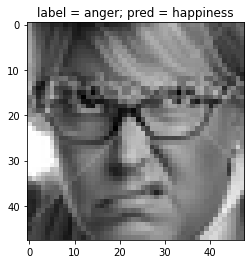

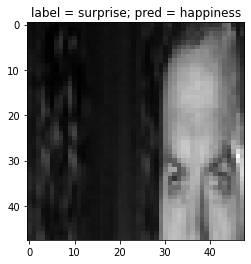

In [121]:
it = iter(testloader)
out = it.next()
labels = out[0]
imgs= out[1]
preds = model(imgs.float()).argmax(dim=1).numpy()

for i in range(2):
    img = imgs[i][0]
    plt.figure()
    plt.imshow(img,cmap='gray')
    plt.title("label = "+class_names[labels[i]]+"; pred = "+class_names[preds[0]])